In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-15 12:29:41.692016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [2]:
# generate numerical values for each batch category
from sklearn.preprocessing import LabelEncoder
# set up categories variable
categories = adata.obs['batch']
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories = label_encoder.fit_transform(categories)
numerical_categories.shape

(450,)

In [3]:
#normalizaiton
gene_expression_data = adata.layers['logcounts']
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_samples = adata.shape[0]
number_genes = adata.shape[1]
input_dim = number_genes

In [4]:
# input_shape = gene_expression_data[0, :].shape  # This should be (12165,) if that's the feature count
# encoding_dim = 64  # This is the size of the encoded representation

input_shape = (12165,)  # Set to match your actual data
encoding_dim = 64  # Output dimension

In [5]:
from keras import layers, models

# Define the input shape
input_shape = (12165,)  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(12165,)))  # Set to match the input shape of 12165
    model.add(layers.Dense(256, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='linear'))  # Encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(64,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense(128, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12165, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

In [6]:
# Define the domain classifier function
def build_domain_classifier(input_shape, num_domains):
    model = models.Sequential()    
    model.add(layers.Input(shape=input_shape))    
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(32, activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    return model

In [7]:
# establishing the gradietn reversl layer
# should only matter during backprop
# higher lambda penalizes correct domain identificaiton

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=1.0, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [24]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier((64,), 9)  # Assuming build_domain_classifier() is defined

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 32

# Training loop
num_epochs = 10

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create a combined model for the encoder and decoder if training together
combined_model = models.Sequential([encoder, decoder])

# Compile combined model
combined_model.compile(optimizer='adam', loss='mean_squared_error')  # Use an appropriate loss for your case

In [25]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=100.0)  # Instantiate GRL

for epoch in range(num_epochs):
    for step in range(num_steps_per_epoch):
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=False)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        with tf.GradientTape(persistent=True) as tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)
            
            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Train on reconstruction loss
        encoder_gradients = tape.gradient(reconstruction_loss, encoder.trainable_variables)
        decoder_gradients = tape.gradient(reconstruction_loss, decoder.trainable_variables)
        
        # Apply gradients
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))

        # Print out scalar loss values for reconstruction
        print(f"Epoch {epoch + 1}/{num_epochs}, Reconstruction Loss: {reconstruction_loss.numpy()}")

        # Now, train on domain loss
        with tf.GradientTape(persistent=True) as tape:
            # Use the same encoded output for domain classification
            domain_output = discriminator(GradientReversalLayer()(encoded_output), training=True)

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)

        # Train on domain loss
        discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)
        
        # Apply gradients to the discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Print out scalar loss values for domain loss
        print(f"Epoch {epoch + 1}/{num_epochs}, Domain Loss: {domain_loss.numpy()}")

Epoch 1/10, Reconstruction Loss: 0.09076128900051117
Epoch 1/10, Domain Loss: 2.9528839588165283
Epoch 1/10, Reconstruction Loss: 0.08915074169635773
Epoch 1/10, Domain Loss: 2.7559776306152344
Epoch 1/10, Reconstruction Loss: 0.0896434336900711
Epoch 1/10, Domain Loss: 2.7160332202911377
Epoch 1/10, Reconstruction Loss: 0.08799584954977036
Epoch 1/10, Domain Loss: 2.965102434158325
Epoch 1/10, Reconstruction Loss: 0.08701928704977036
Epoch 1/10, Domain Loss: 2.5193746089935303
Epoch 1/10, Reconstruction Loss: 0.08911655098199844
Epoch 1/10, Domain Loss: 2.645730495452881
Epoch 1/10, Reconstruction Loss: 0.08723634481430054
Epoch 1/10, Domain Loss: 2.4544594287872314
Epoch 1/10, Reconstruction Loss: 0.08710901439189911
Epoch 1/10, Domain Loss: 2.5587775707244873
Epoch 1/10, Reconstruction Loss: 0.08622027933597565
Epoch 1/10, Domain Loss: 2.5495176315307617
Epoch 1/10, Reconstruction Loss: 0.0859246701002121
Epoch 1/10, Domain Loss: 2.6193177700042725
Epoch 1/10, Reconstruction Loss: 0

In [28]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=20.0)  # Instantiate GRL

# Training loop
for epoch in range(num_epochs):
    for step in range(num_steps_per_epoch):
        # Get a batch of data (as you already have)
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=False)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        with tf.GradientTape(persistent=True) as tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)

            # Apply gradient reversal
            encoded_output_grl = grl(encoded_output)

            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Domain output (using the output from GRL)
            domain_output = discriminator(encoded_output_grl, training=True)

            # Calculate losses
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))  # Mean squared error
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)  # Cross-entropy loss
            domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

            # Total loss
            total_loss = reconstruction_loss + domain_loss

        # Calculate gradients and update weights
        encoder_gradients = tape.gradient(total_loss, encoder.trainable_variables)
        decoder_gradients = tape.gradient(total_loss, decoder.trainable_variables)
        discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)

        # Apply gradients
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Print out scalar loss values
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss.numpy()}, "
          f"Reconstruction Loss: {reconstruction_loss.numpy()}, Domain Loss: {domain_loss.numpy()}")

Epoch 1/10, Total Loss: 4.883905410766602, Reconstruction Loss: 0.0021378155797719955, Domain Loss: 4.881767749786377
Epoch 2/10, Total Loss: 5.890177249908447, Reconstruction Loss: 0.002296782098710537, Domain Loss: 5.887880325317383
Epoch 3/10, Total Loss: 7.0620574951171875, Reconstruction Loss: 0.0015941078308969736, Domain Loss: 7.0604634284973145
Epoch 4/10, Total Loss: 6.88341760635376, Reconstruction Loss: 0.002184702781960368, Domain Loss: 6.881232738494873
Epoch 5/10, Total Loss: 6.417456150054932, Reconstruction Loss: 0.002049099188297987, Domain Loss: 6.415407180786133
Epoch 6/10, Total Loss: 6.7782979011535645, Reconstruction Loss: 0.0015675354516133666, Domain Loss: 6.776730537414551
Epoch 7/10, Total Loss: 6.353211402893066, Reconstruction Loss: 0.001716229016892612, Domain Loss: 6.351495265960693
Epoch 8/10, Total Loss: 6.145127296447754, Reconstruction Loss: 0.001655753469094634, Domain Loss: 6.143471717834473
Epoch 9/10, Total Loss: 5.7828049659729, Reconstruction Los

In [ ]:
# num_domains = len(np.unique(categories))
# X_data = gene_expression_data
# y_domains = numerical_categories

# grl = GradientReversalLayer(lambda_value=1.0)


# for epoch in range(num_epochs):
#     for step in range(num_steps_per_epoch):
#         # Get a batch of data
#         batch_indices = []
#         for domain in range(num_domains):
#             domain_indices = np.where(y_domains == domain)[0]
#             domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=False)
#             batch_indices.append(domain_batch_indices)

#         X_batch = X_data[np.concatenate(batch_indices)]
#         y_true_batch = y_domains[np.concatenate(batch_indices)]
#         y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

#         with tf.GradientTape(persistent=True) as tape:
#             # Encode
#             encoded_output = encoder(X_batch, training=True)
#             # Decode
#             decoded_output = decoder(encoded_output, training=True)

#             # Domain output
#             domain_output = discriminator(encoded_output, training=True)

#             # Calculate losses
#             reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))  # Scalar
#             domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)  # Shape: (batch_size, num_classes)
#             domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

#             # Total loss
#             total_loss = reconstruction_loss + domain_loss

#         # Calculate gradients and update weights
#         encoder_gradients = tape.gradient(total_loss, encoder.trainable_variables)
#         decoder_gradients = tape.gradient(total_loss, decoder.trainable_variables)
#         discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)

#         # Apply gradients
#         encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
#         decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     # Print out scalar loss values
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss.numpy()}, Reconstruction Loss: {reconstruction_loss.numpy()}, Domain Loss: {domain_loss.numpy()}")

In [20]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=1000.0)  # Instantiate GRL

for epoch in range(num_epochs):
    # Initialize accumulators for losses
    total_reconstruction_loss = 0.0
    total_domain_loss = 0.0
    num_batches = 0

    for step in range(num_steps_per_epoch):
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=False)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        # Training on reconstruction loss
        with tf.GradientTape(persistent=True) as tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)
            
            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Train on reconstruction loss
        encoder_gradients = tape.gradient(reconstruction_loss, encoder.trainable_variables)
        decoder_gradients = tape.gradient(reconstruction_loss, decoder.trainable_variables)
        
        # Apply gradients
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))

        # Accumulate reconstruction loss
        total_reconstruction_loss += reconstruction_loss.numpy()
        
        # Now, train on domain loss
        with tf.GradientTape(persistent=True) as tape:
            # Use the same encoded output for domain classification
            domain_output = discriminator(grl(encoded_output), training=True)  # Apply GRL here

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)

        # Train on domain loss
        discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)
        
        # Apply gradients to the discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Accumulate domain loss
        total_domain_loss += domain_loss.numpy()
        num_batches += 1  # Increment the batch counter

    # Calculate averages for the epoch
    average_reconstruction_loss = total_reconstruction_loss / num_batches
    average_domain_loss = total_domain_loss / num_batches

    # Print out average loss values for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}, Average Domain Loss: {average_domain_loss}")

Epoch 1/10, Average Reconstruction Loss: 0.001350453680580748, Average Domain Loss: 0.11919221734361989
Epoch 2/10, Average Reconstruction Loss: 0.0013730520316000497, Average Domain Loss: 0.11916973654712949
Epoch 3/10, Average Reconstruction Loss: 0.0013532662830714668, Average Domain Loss: 0.10273042933217116
Epoch 4/10, Average Reconstruction Loss: 0.0013530682606090391, Average Domain Loss: 0.11135877961558956
Epoch 5/10, Average Reconstruction Loss: 0.0013115541327611677, Average Domain Loss: 0.08762508098568235
Epoch 6/10, Average Reconstruction Loss: 0.0012830965985943163, Average Domain Loss: 0.0914269829435008
Epoch 7/10, Average Reconstruction Loss: 0.0012578841082618705, Average Domain Loss: 0.12155190349689551
Epoch 8/10, Average Reconstruction Loss: 0.0012284897467387573, Average Domain Loss: 0.08585346516753946
Epoch 9/10, Average Reconstruction Loss: 0.0012265553564897605, Average Domain Loss: 0.0847758324816823
Epoch 10/10, Average Reconstruction Loss: 0.00122739823668

15/15 [==============================] - 0s 2ms/step
(450, 64)


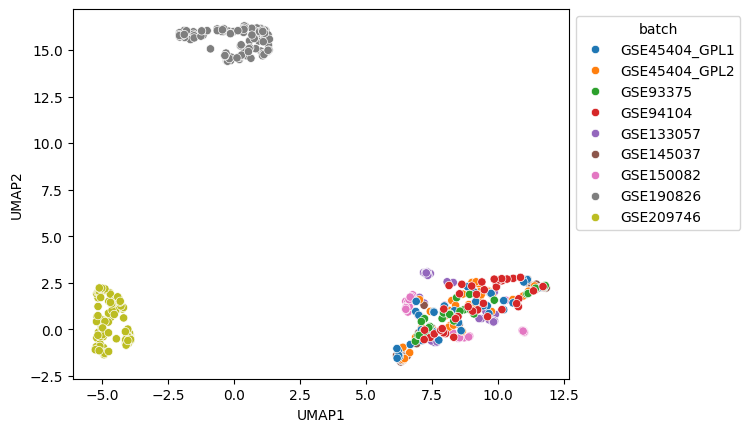

In [29]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
categories =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

15/15 [==============================] - 0s 2ms/step
(450, 64)


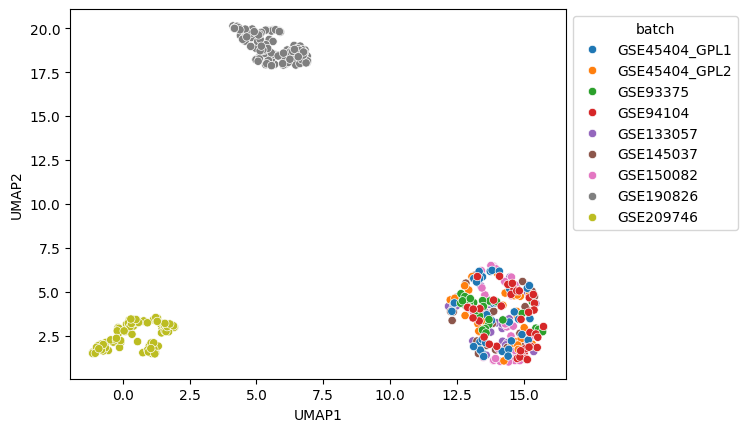

In [26]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
categories =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

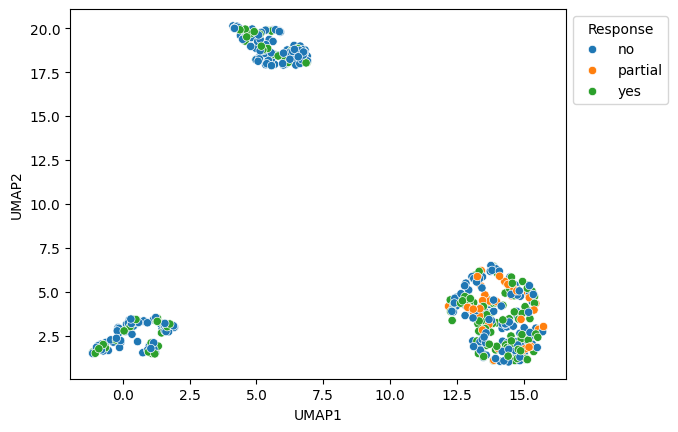

In [27]:
#checking response variable separation
categories =  adata.obs['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))